In [1]:
from operator import concat

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df_body = pd.read_csv("../data/StanceDetection/train_bodies.csv")
df_stance = pd.read_csv("../data/StanceDetection/train_stances.csv")

In [3]:
df_body.head()

,Body ID,articleBody
0,0,A small meteorite crashed into a wooded area i...
1,4,Last week we hinted at what was to come as Ebo...
2,5,(NEWSER) – Wonder how long a Quarter Pounder w...
3,6,"Posting photos of a gun-toting child online, I..."
4,7,At least 25 suspected Boko Haram insurgents we...


In [4]:
df_stance.head()

,Headline,Body ID,Stance
0,Police find mass graves with at least '15 bodi...,712,unrelated
1,Hundreds of Palestinians flee floods in Gaza a...,158,agree
2,"Christian Bale passes on role of Steve Jobs, a...",137,unrelated
3,HBO and Apple in Talks for $15/Month Apple TV ...,1034,unrelated
4,Spider burrowed through tourist's stomach and ...,1923,disagree


Merge the datasets under the `Body ID` feature

In [5]:
df = df_stance.merge(df_body, how="left", left_on="Body ID", right_on="Body ID")

In [6]:
df.head()

,Headline,Body ID,Stance,articleBody
0,Police find mass graves with at least '15 bodi...,712,unrelated,Danny Boyle is directing the untitled film\n\n...
1,Hundreds of Palestinians flee floods in Gaza a...,158,agree,Hundreds of Palestinians were evacuated from t...
2,"Christian Bale passes on role of Steve Jobs, a...",137,unrelated,30-year-old Moscow resident was hospitalized w...
3,HBO and Apple in Talks for $15/Month Apple TV ...,1034,unrelated,(Reuters) - A Canadian soldier was shot at the...
4,Spider burrowed through tourist's stomach and ...,1923,disagree,"Fear not arachnophobes, the story of Bunbury's..."


Let's check any duplicates

In [7]:
duplicates = df.duplicated(subset=["Headline", "Body ID"]).sum()
duplicates

np.int64(402)

In [8]:
df["Stance"].value_counts()

Stance
unrelated    36545
discuss       8909
agree         3678
disagree       840
Name: count, dtype: int64

In [9]:
df["Stance"].value_counts(normalize=True)

Stance
unrelated    0.731310
discuss      0.178280
agree        0.073601
disagree     0.016809
Name: proportion, dtype: float64

As explained by the dataset source, most of our labels are unrelated and the main purpose is to create this unbalanced data to avoid overfitting. So that means when modeling we will need to use SMOTES or undersampling or something like that to fix that.

Let's take a look now on the length of our text

In [10]:
df["headline_len_chars"] = df["Headline"].str.len()
df["headline_len_words"] = df["Headline"].str.split().apply(len)
df["body_len_chars"] = df["articleBody"].str.len()
df["body_len_words"] = df["articleBody"].str.split().apply(len)

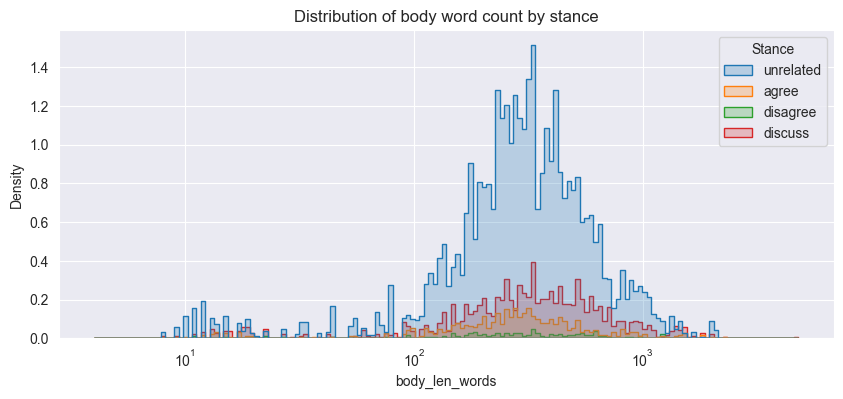

In [11]:
plt.figure(figsize=(10,4))
sns.histplot(data=df, x="body_len_words", log_scale=True, hue="Stance", element="step", stat="density")
plt.title("Distribution of body word count by stance")
plt.show()

Let's compare now how the word count changes for the body and headline

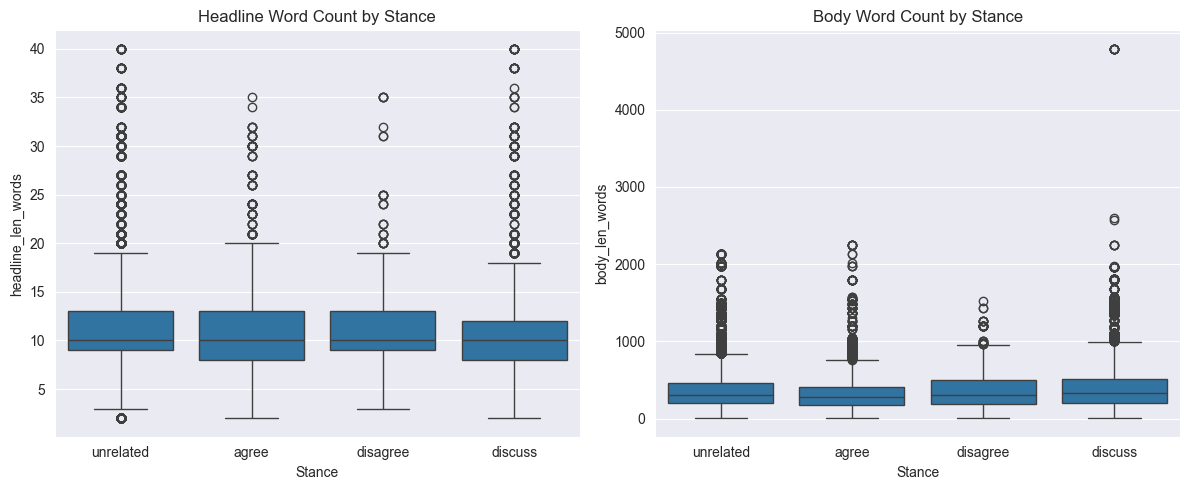

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.boxplot(data=df, x="Stance", y="headline_len_words", ax=axes[0])
sns.boxplot(data=df, x="Stance", y="body_len_words", ax=axes[1])
axes[0].set_title("Headline Word Count by Stance")
axes[1].set_title("Body Word Count by Stance")
plt.tight_layout()
plt.show()

Let's look now at the number of headline words in the body

In [13]:
def headline_body_overlap(row):
    headline_words = set(row["Headline"].lower().split())
    body_words = set(row["articleBody"].lower().split())
    overlap = len(headline_words & body_words)
    return overlap / (len(headline_words) if len(headline_words)>0 else 1)

In [14]:
df["headline_body_overlap_ratio"] = df.apply(headline_body_overlap, axis=1)

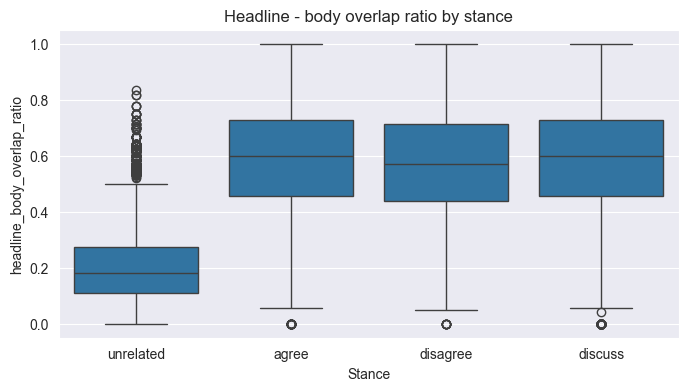

In [15]:
plt.figure(figsize=(8,4))
sns.boxplot(data=df, x="Stance", y="headline_body_overlap_ratio")
plt.title("Headline - body overlap ratio by stance")
plt.show()

As expected, our three main classes that are related to the headline and body contains more words that are found in the headline. Note that even some unrelated articles have some words that are also contained in the headline.

TD-IDF similarity

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [17]:
tfidf = TfidfVectorizer(stop_words="english", max_features=5000)
tfidf_matrix = tfidf.fit_transform(df["Headline"].tolist() + df["articleBody"].tolist())

In [18]:
headline_tfidf = tfidf_matrix[:len(df)]

In [19]:
body_tfidf = tfidf_matrix[len(df):]

In [20]:
cosine_scores = [cosine_similarity(headline_tfidf[i], body_tfidf[i])[0][0] for i in range(len(df))]
df["cosine_sim"] = cosine_scores

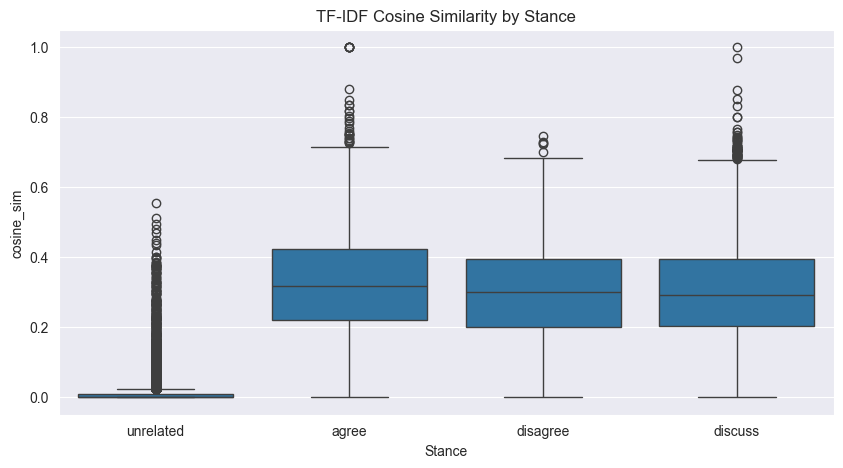

In [21]:
plt.figure(figsize=(10,5))
sns.boxplot(data=df, x="Stance", y="cosine_sim")
plt.title("TF-IDF Cosine Similarity by Stance")
plt.show()

Again, as expected, there's very little lexical similiarities between unrelated target and its body + headline. On the other hand, the other three classes have a fairly similiarity between headline and body, but what calls my attention the most is that `agree` and `discuss` have way more outliers than `disagree`. Does this mean that when the headline and body agrees or are discussed, they are more similar than when they disagree?

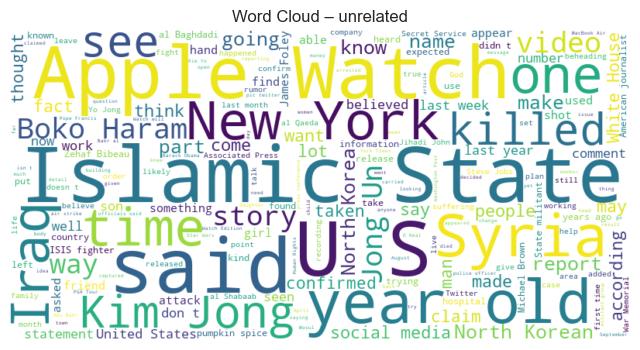

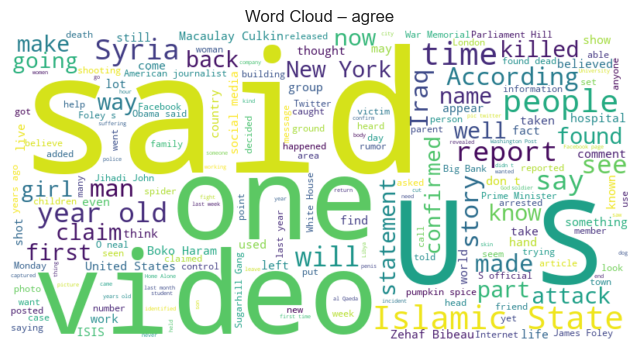

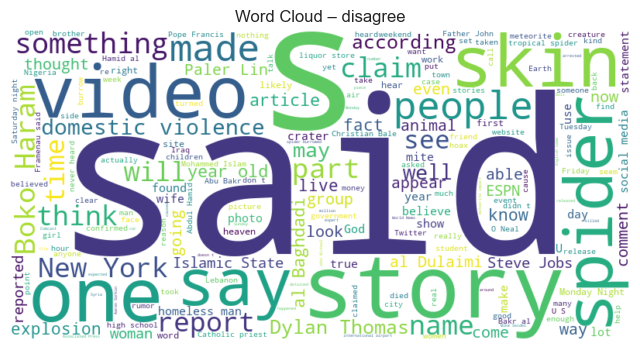

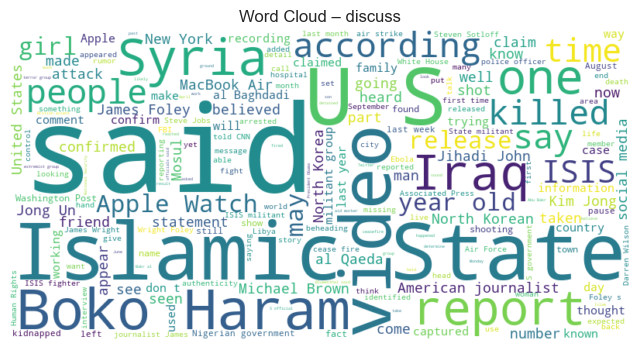

In [22]:
from wordcloud import WordCloud, STOPWORDS

for stance in df["Stance"].unique():
    text = " ".join(df[df["Stance"] == stance]["articleBody"].astype(str).tolist())
    plt.figure(figsize=(8,5))
    wc = WordCloud(stopwords=STOPWORDS, background_color="white", width=800, height=400).generate(text)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Word Cloud – {stance}")
    plt.show()

Interesting to see how both `unrelated` and `discuss` have a more random number of words, many words take the highlight, but when we look into `agree` and `disagree` we see a different shift, the word `said` is used more than any other word, which matches what we saw in the Fakenews EDA notebook

In [23]:
from textblob import TextBlob

df["headline_sentiment"] = df["Headline"].apply(lambda x: TextBlob(x).sentiment.polarity)

In [24]:
df["body_sentiment"] = df["articleBody"].apply(lambda x: TextBlob(x).sentiment.polarity)

In [25]:
import textstat
df["readability"] = df["articleBody"].apply(lambda x: textstat.flesch_reading_ease(x))

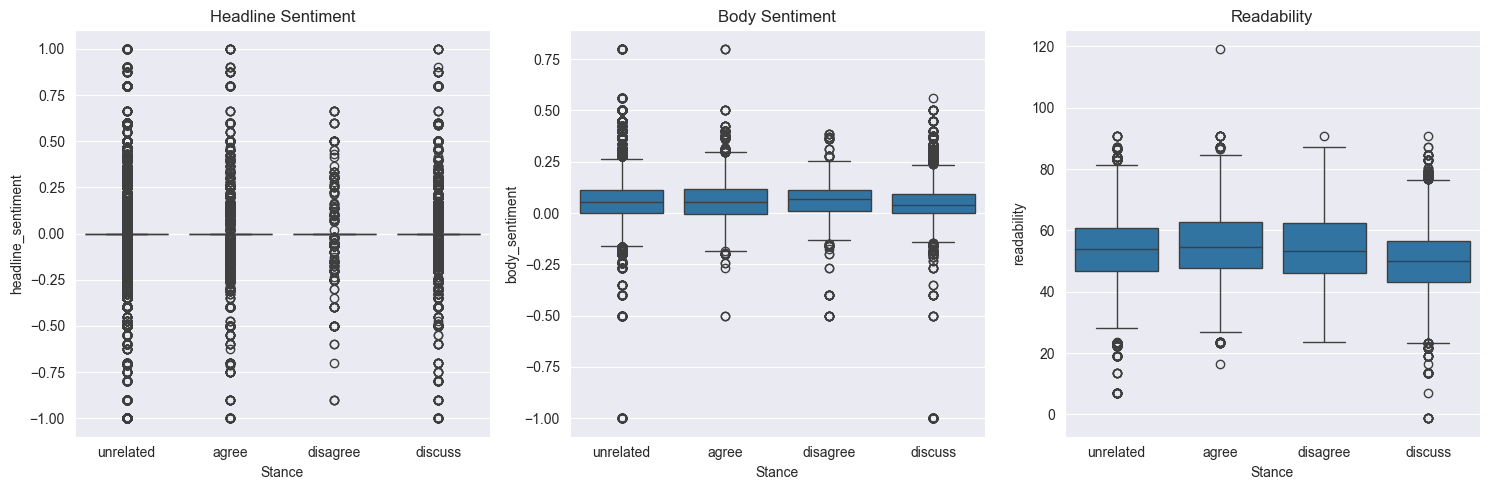

In [26]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
sns.boxplot(data=df, x="Stance", y="headline_sentiment", ax=axes[0])
sns.boxplot(data=df, x="Stance", y="body_sentiment", ax=axes[1])
sns.boxplot(data=df, x="Stance", y="readability", ax=axes[2])
axes[0].set_title("Headline Sentiment")
axes[1].set_title("Body Sentiment")
axes[2].set_title("Readability")
plt.tight_layout()
plt.show()

Observations:
- Headline sentiment graph
    - `Disagree` has the most neureal sentiment in comparison to the other features
- Body sentiment
    - Surprisingly, our quantiles are very similar, but we gotta look at these outliers. `Unrelated` and `discuss` have more outliers than the rest of the classes. That might be a clue.
- Readability
    - I would expect the `discuss` class to have less readability since not everyone can explain things well, sometimes it gets too wordy or there are more references to other articles, images, videos, etc.

In [27]:
corr_features = ["headline_len_words", "body_len_words", "cosine_sim",
                 "headline_sentiment", "body_sentiment", "readability"]

                    headline_len_words  body_len_words  cosine_sim  \
headline_len_words                1.00            0.00        0.00   
body_len_words                    0.00            1.00        0.03   
cosine_sim                        0.00            0.03        1.00   
headline_sentiment               -0.00           -0.00        0.00   
body_sentiment                    0.00           -0.07       -0.02   
readability                       0.03           -0.11       -0.05   

                    headline_sentiment  body_sentiment  readability  
headline_len_words               -0.00            0.00         0.03  
body_len_words                   -0.00           -0.07        -0.11  
cosine_sim                        0.00           -0.02        -0.05  
headline_sentiment                1.00            0.03         0.01  
body_sentiment                    0.03            1.00         0.16  
readability                       0.01            0.16         1.00  


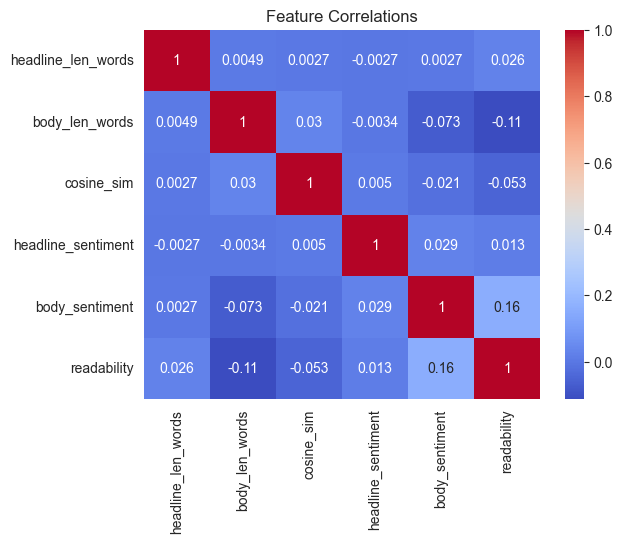

In [28]:
print(df[corr_features].corr().round(2))
sns.heatmap(df[corr_features].corr(), annot=True, cmap="coolwarm")
plt.title("Feature Correlations")
plt.show()

The strongest correlation is between readability and body_sentiment, but overall not a strong correlation between our features

In [30]:
df.to_csv("../data/preprocessed/master_stance.csv", index=False)